<h1>Proposal: Running Log Database</h1>
<h4>By Patrick Chesnut</h4>

<h3>Grading Rubric</h3>

- 10 pts  : Was a video included in the project submission?
    - Link to video: https://youtu.be/FFUFeZQajfU
    - Link to github: https://github.com/chesnutpc/RunningDatabase/blob/master/Project_Part3.ipynb
- 5 pts   : Does the project contain at least 3 tables?
    - See section 2.0-2.1
- 5 pts   : Are there relationships between table items (foreign keys)?
    - See section 2.0-2.1
- 5 pts   : Are there constraints on the table columns?
    - See section 2.1
- 5 pts   : Did the writeup/video show SQL statements (and any accompanying code) for all table creation?
    - See section 2.1
- 5 pts   : Did the writeup/video show SQL statements for the insertion of data?
    - See sections 2.2, 2.3, 4.0
- 5 pts   : Did the writeup/video show SQL statements for UPDATEs?
    - See sections 3.1, 3.2, 3.3 for trigger testing update statements
    - See section 7.0 for standalone example
- 5 pts   : Did the writeup/video show SQL statements for queries?
    - See section 6.0
- 5 pts   : Do the tables include Indexes ? 
    - See section 5.0
- 10 pts  : Did the writeup/video show the code and execution of the trigger(s)?
    - See sections 3.1, 3.2, 3.3
- 5 pts   : Did the writeup/video show the Join between at least 3 tables?
    - See section 6.0
- 5 pts   : Did the writeup/video show grouping of the data on the Join between at least 3 tables?
    - See section 6.0
- 5 pts   : Did the writeup/video show aggregation on the Join between at least 3 tables?
    - See section 6.0
- 5 pts   : Did the writeup/video show the deletion of items that have foreign keys?
    - See section 8.0


<h2>1.0 - Motivation for the Database Project</h2>

This project aims to help runners track and analyze their running activities, providing valuable insights into their performance, health, and progress. The primary motivation is to create an intuitive and efficient database for managing personal running data. This database will enable users to easily retrieve and visualize information about their runs, such as time, weather conditions, shoes worn, run length, pace, and heart rate. By centralizing this data, users can make informed decisions to improve their running experience, optimize training, and remain motivated to achieve their running goals.


<h2>2.0 Tables, relationships, constraints</h2>

The Running Log Database will involve multiple related data tables to store the various aspects of each run.  The entity relationship diagram below sketches out the proposed database design.  There are four tables: User, Shoes, Run, and RunDataPoint.  The arrows below specify the relations between the tables.  There is a one-to-many relationship between User and Run (i.e. a user can have multiple runs, but a run must be associated with only one user).  Similarly, there is a one-to-many relationship between User and Shoes (i.e. a user can have multiple mulitple shoes, but a shoe must be associated with only one user).  There is a one-to-one relationship between Shoes and Run (i.e only one pair of shoes are allowed to be used for each run).  Finally, there is a one-to-many relationship between Run and RunDataPoint (i.e. a run will consist of many datapoints, but each datapoint can only be associated with one run).

SQLite is used for the creation and management of the database. SQLite is an ideal choice for this project due to its simplicity and ease of integration with Python and Jupyter Notebooks. It is well-suited for personal applications and is capable of handling the expected data volume efficiently.


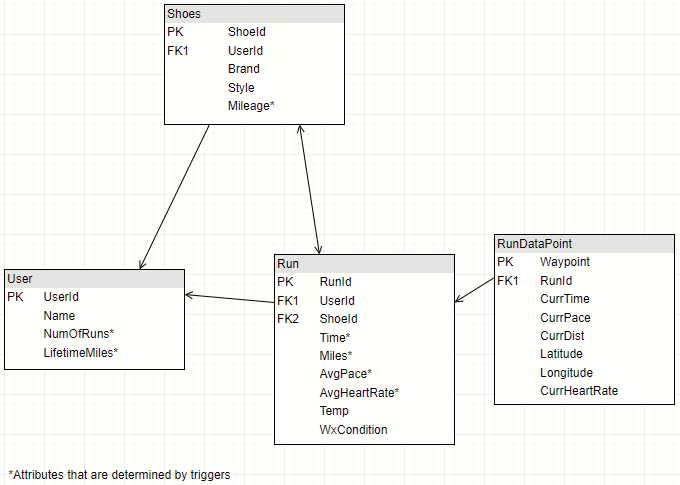

In [1]:
from IPython import display
display.Image("./Run_DB_ERD.PNG")

In [2]:
%reload_ext sql
%sql sqlite:///runs.db

'Connected: @runs.db'

<h3>2.1 - Table Creation</h3>
The code below creates the four tables and the relations between them.  Foreign key and check constraints are used throughout.

In [3]:
%%sql
DROP TABLE IF EXISTS User;
DROP TABLE IF EXISTS Shoes;
DROP TABLE IF EXISTS Run;
DROP TABLE IF EXISTS RunDataPoint;

CREATE TABLE User (
    UserId INTEGER PRIMARY KEY,
    name VARCHAR(255) NOT NULL,
    NumOfRuns INT NOT NULL,
    LifetimeMiles FLOAT CHECK (LifetimeMiles >= 0)
);

CREATE TABLE Shoes (
    ShoeId INTEGER PRIMARY KEY,
    UserId VARCHAR(255) NOT NULL,
    Brand VARCHAR(255) NOT NULL,
    Style VARCHAR(255) NOT NULL,
    Mileage FLOAT CHECK (Mileage >= 0),
    CONSTRAINT FK_UserShoes FOREIGN KEY (UserId) REFERENCES User(UserId)
);

CREATE TABLE Run (
    RunId INTEGER PRIMARY KEY,
    UserId INT NOT NULL,
    ShoeId INT NOT NULL,
    Time INT CHECK (Time >= 0),
    Miles FLOAT CHECK (Miles >= 0),
    AvgPace FLOAT CHECK (AvgPace >= 0),
    AvgHeartRate FLOAT CHECK (AvgHeartRate >= 0),
    Temp INT NOT NULL CHECK (Temp >= -20 AND Temp <= 120),
    WxCondition VARCHAR(255) NOT NULL,
    CONSTRAINT CHK_WxCondition CHECK (WxCondition IN ("Sunny","Cloudy","Partly Cloudy","Rain","Snow")),
    CONSTRAINT FK_RunUser FOREIGN KEY (UserId) REFERENCES User(UserId),
    CONSTRAINT FK_RunShoes FOREIGN KEY (ShoeId) REFERENCES Shoes(ShoeId)
);

CREATE TABLE RunDataPoint (
    Waypoint INTEGER PRIMARY KEY,
    RunId INT NOT NULL,
    CurrTime INT NOT NULL CHECK (CurrTime >= 0),
    CurrPace FLOAT NOT NULL CHECK (CurrPace >= 0),
    CurrDist FLOAT NOT NULL CHECK (CurrDist >= 0),
    Latitude FLOAT NOT NULL CHECK (Latitude >= -90 AND Latitude <= 90),
    Longitude FLOAT NOT NULL CHECK (Longitude >= -180 AND Longitude <= 180),
    CurrHeartRate INT NOT NULL CHECK (CurrHeartRate >= 30 AND CurrHeartRate <= 220),
    CONSTRAINT FK_RunDataPointRunId FOREIGN KEY (RunId) REFERENCES Run(RunId)
);

 * sqlite:///runs.db
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


[]

<h3>2.2 Populating User Table</h3>
The User table is populated with three runner: Steve, Kara, and Forest.  All have zero runs and zero lifetime miles.

In [4]:
%%sql
INSERT INTO User (Name, NumOfRuns, LifetimeMiles)
VALUES
('Steve', 0, 0),
('Kara', 0, 0),
('Forest', 0, 0);

SELECT * FROM User;


 * sqlite:///runs.db
3 rows affected.
Done.


UserId,name,NumOfRuns,LifetimeMiles
1,Steve,0,0.0
2,Kara,0,0.0
3,Forest,0,0.0


<h3>2.3 - Populating Shoes Table</h3>
Each of the three runners will have 2 pairs of shoes.  All shoes will initially have no mileage.

In [5]:
%%sql
INSERT INTO Shoes (UserId, Brand, Style, Mileage)
VALUES
(1,"Asics","Kayano", 0),
(1,"Saucony","Endorphine", 0),
(2,"Asics","GT-2000", 0),
(2,"Hoka","Clifton", 0),
(3,"Hoka","Gaviota", 0),
(3,"Nike","Vaporfly", 0);

SELECT * FROM Shoes;

 * sqlite:///runs.db
6 rows affected.
Done.


ShoeId,UserId,Brand,Style,Mileage
1,1,Asics,Kayano,0.0
2,1,Saucony,Endorphine,0.0
3,2,Asics,GT-2000,0.0
4,2,Hoka,Clifton,0.0
5,3,Hoka,Gaviota,0.0
6,3,Nike,Vaporfly,0.0


<h2>3.0 Trigger Creation and Testing</h2>
Triggers need to be created now before the other two tables are populated as many attributes are calculated based on triggers.  Triggers are created here to update NumOfRuns and LifetimeMiles in the User table; Mileage in the Shoes table; and Time, Miles, AvgPace, and AvgHeartRate in the Run table.

<h3>3.1 - Triggers for User Table</h3>
Here Triggers for the User table are created and tested.  Triggers will keep track of the NumOfRuns and the LifetimeMiles attributes.

In [6]:
%%sql
-- Triggers for NumOfRuns
DROP TRIGGER IF EXISTS increment_NumOfRuns;
create trigger increment_NumOfRuns
after insert on Run
for each row
begin
  update User set NumOfRuns = NumOfRuns + 1 where
  UserId = new.UserId;
end;

DROP TRIGGER IF EXISTS decrement_NumOfRuns;
create trigger decrement_NumOfRuns
after delete on Run
for each row
begin
  update User set NumOfRuns = NumOfRuns - 1 where
  UserId = old.UserId;
end;

-- Triggers for LifetimeMiles
DROP TRIGGER IF EXISTS increase_insert_LifetimeMiles;
create trigger increase_insert_LifetimeMiles
after insert on Run
for each row
begin
  update User set LifetimeMiles = ROUND(LifetimeMiles + new.Miles, 2) where
  UserId = new.UserId;
end;

DROP TRIGGER IF EXISTS increase_update_LifetimeMiles;
create trigger increase_update_LifetimeMiles
after update on Run
for each row
begin
  update User set LifetimeMiles = ROUND(LifetimeMiles - old.Miles + new.Miles, 2) where
  UserId = new.UserId;
end;

DROP TRIGGER IF EXISTS decrease_LifetimeMiles;
create trigger decrease_LifetimeMiles
after delete on Run
for each row
begin
  update User set LifetimeMiles = IFNULL(NULLIF(ROUND(LifetimeMiles - old.Miles, 2),''),0) where
  UserId = old.UserId;
end;


 * sqlite:///runs.db
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


[]

User table triggers are now tested.  First we insert two rows into Run, then we update a run, and finally we delete a run.

In [7]:
%%sql
-- Test of triggers affecting User table
-- Insert run
INSERT INTO Run (RunId, UserId, ShoeId, Time, Miles, AvgPace, AvgHeartRate, Temp, WxCondition)
VALUES
(1, 1, 1, 605, 1.25, 5.6, 125, 60, "Sunny"),
(2, 1, 1, 610, 1.25, 5.6, 125, 60, "Rain");

-- Update run
UPDATE Run
SET Miles = 1.75
WHERE RunId = 2;

SELECT * FROM User;


 * sqlite:///runs.db
2 rows affected.
1 rows affected.
Done.


UserId,name,NumOfRuns,LifetimeMiles
1,Steve,2,3.0
2,Kara,0,0.0
3,Forest,0,0.0


In [8]:
%%sql
-- Delete runs
DELETE FROM Run WHERE UserId = 1;
SELECT * FROM User;

 * sqlite:///runs.db
2 rows affected.
Done.


UserId,name,NumOfRuns,LifetimeMiles
1,Steve,0,0.0
2,Kara,0,0.0
3,Forest,0,0.0


<h3>3.2 Triggers for Shoes table</h3>
Here Triggers for the Shoes table are created and tested. The triggers will keep track of the Mileage attribute.

In [9]:
%%sql
-- Triggers for Shoe Mileage
DROP TRIGGER IF EXISTS increase_insert_Mileage;
create trigger increase_insert_Mileage
after insert on Run
for each row
begin
  update Shoes set Mileage = ROUND(Mileage + new.Miles, 2) where
  ShoeId = new.ShoeId;
end;

DROP TRIGGER IF EXISTS increase_update_Mileage;
create trigger increase_update_Mileage
after update on Run
for each row
begin
  update Shoes set Mileage = ROUND(Mileage - old.Miles + new.Miles, 2) where
  ShoeId = new.ShoeId;
end;

DROP TRIGGER IF EXISTS decrease_Mileage;
create trigger decrease_Mileage
after delete on Run
for each row
begin
  update Shoes set Mileage = IFNULL(NULLIF(ROUND(Mileage - old.Miles, 2),''),0) where
  ShoeId = old.ShoeId;
end;



 * sqlite:///runs.db
Done.
Done.
Done.
Done.
Done.
Done.


[]

Now, the triggers are tested by first inserting runs, then updating a run and finally deleting the runs.

In [10]:
%%sql
-- Test of triggers affecting User table
-- Insert run
INSERT INTO Run (RunId, UserId, ShoeId, Time, Miles, AvgPace, AvgHeartRate, Temp, WxCondition)
VALUES
(1, 1, 1, 605, 2.0, 5.6, 125, 60, "Sunny"),
(2, 1, 1, 610, 1.0, 5.6, 125, 60, "Rain"),
(3, 1, 2, 610, 5, 5.6, 125, 60, "Rain");

-- Update run
UPDATE Run
SET Miles = 1.5
WHERE RunId = 2;

SELECT * FROM Shoes;

 * sqlite:///runs.db
3 rows affected.
1 rows affected.
Done.


ShoeId,UserId,Brand,Style,Mileage
1,1,Asics,Kayano,3.5
2,1,Saucony,Endorphine,5.0
3,2,Asics,GT-2000,0.0
4,2,Hoka,Clifton,0.0
5,3,Hoka,Gaviota,0.0
6,3,Nike,Vaporfly,0.0


In [11]:
%%sql
DELETE FROM Run WHERE UserId = 1;
SELECT * FROM Shoes;

 * sqlite:///runs.db
3 rows affected.
Done.


ShoeId,UserId,Brand,Style,Mileage
1,1,Asics,Kayano,0.0
2,1,Saucony,Endorphine,0.0
3,2,Asics,GT-2000,0.0
4,2,Hoka,Clifton,0.0
5,3,Hoka,Gaviota,0.0
6,3,Nike,Vaporfly,0.0


<h3>3.3 - Triggers for Run Table</h3>
Here Triggers for the Run table are created and tested. The triggers will keep track of the Time, Miles, AvgPace, and AvgHeartRate attributes.

In [12]:
%%sql
-- Triggers for Time
DROP TRIGGER IF EXISTS RunDataPoint_insert_Time;
create trigger RunDataPoint_insert_Time
after insert on RunDataPoint
for each row
begin
  update Run set Time = (SELECT MAX(CurrTime) FROM RunDataPoint WHERE RunId = new.RunId) where
  RunId = new.RunId;
end;

DROP TRIGGER IF EXISTS RunDataPoint_update_Time;
create trigger RunDataPoint_update_Time
after update on RunDataPoint
for each row
begin
  update Run set Time = (SELECT MAX(CurrTime) FROM RunDataPoint WHERE RunId = new.RunId) where
  RunId = new.RunId;
end;

DROP TRIGGER IF EXISTS RunDataPoint_delete_Time;
create trigger RunDataPoint_delete_Time
after delete on RunDataPoint
for each row
begin
  update Run set Time = (SELECT MAX(CurrTime) FROM RunDataPoint WHERE RunId = old.RunId) where
  RunId = old.RunId;
end;
-- -----------------------------------------------------------
-- Triggers for Miles
DROP TRIGGER IF EXISTS RunDataPoint_insert_Miles;
create trigger RunDataPoint_insert_Miles
after insert on RunDataPoint
for each row
begin
  update Run set Miles = (SELECT ROUND(MAX(CurrDist),2) FROM RunDataPoint WHERE RunId = new.RunId) where
  RunId = new.RunId;
end;

DROP TRIGGER IF EXISTS RunDataPoint_update_Miles;
create trigger RunDataPoint_update_Miles
after update on RunDataPoint
for each row
begin
  update Run set Miles = (SELECT ROUND(MAX(CurrDist),2) FROM RunDataPoint WHERE RunId = new.RunId) where
  RunId = new.RunId;
end;

DROP TRIGGER IF EXISTS RunDataPoint_delete_Miles;
create trigger RunDataPoint_delete_Miles
after delete on RunDataPoint
for each row
begin
  update Run set Miles = (SELECT ROUND(MAX(CurrDist),2) FROM RunDataPoint WHERE RunId = old.RunId) where
  RunId = old.RunId;
end;
-- -----------------------------------------------------------
-- Triggers for AvgHeartRate
DROP TRIGGER IF EXISTS RunDataPoint_insert_AvgHeartRate;
create trigger RunDataPoint_insert_AvgHeartRate
after insert on RunDataPoint
for each row
begin
  update Run set AvgHeartRate = (SELECT ROUND(AVG(CurrHeartRate),1) FROM RunDataPoint WHERE RunId = new.RunId) where
  RunId = new.RunId;
end;

DROP TRIGGER IF EXISTS RunDataPoint_update_AvgHeartRate;
create trigger RunDataPoint_update_AvgHeartRate
after update on RunDataPoint
for each row
begin
  update Run set AvgHeartRate = (SELECT ROUND(AVG(CurrHeartRate),1) FROM RunDataPoint WHERE RunId = new.RunId) where
  RunId = new.RunId;
end;

DROP TRIGGER IF EXISTS RunDataPoint_delete_AvgHeartRate;
create trigger RunDataPoint_delete_AvgHeartRate
after delete on RunDataPoint
for each row
begin
  update Run set AvgHeartRate = (SELECT ROUND(AVG(CurrHeartRate),1) FROM RunDataPoint WHERE RunId = old.RunId) where
  RunId = old.RunId;
end;
-- -----------------------------------------------------------
-- Triggers for AvgPace
DROP TRIGGER IF EXISTS RunDataPoint_insert_AvgPace;
create trigger RunDataPoint_insert_AvgPace
after insert on RunDataPoint
for each row
begin
  update Run set AvgPace = (SELECT ROUND(AVG(CurrPace),2) FROM RunDataPoint WHERE RunId = new.RunId) where
  RunId = new.RunId;
end;

DROP TRIGGER IF EXISTS RunDataPoint_update_AvgPace;
create trigger RunDataPoint_update_AvgPace
after update on RunDataPoint
for each row
begin
  update Run set AvgPace = (SELECT ROUND(AVG(CurrPace),2) FROM RunDataPoint WHERE RunId = new.RunId) where
  RunId = new.RunId;
end;

DROP TRIGGER IF EXISTS RunDataPoint_delete_AvgPace;
create trigger RunDataPoint_delete_AvgPace
after delete on RunDataPoint
for each row
begin
  update Run set AvgPace = (SELECT ROUND(AVG(CurrPace),2) FROM RunDataPoint WHERE RunId = old.RunId) where
  RunId = old.RunId;
end;


 * sqlite:///runs.db
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


[]

Now, the triggers will be tested.  We start by inserting a run and then 3 run data points.

In [13]:
%%sql
-- Insert Run
INSERT INTO Run (RunId, UserId, ShoeId, Time, Miles, AvgPace, AvgHeartRate, Temp, WxCondition)
VALUES
(1, 1, 1, 0, 0, 0, 0, 60, "Sunny");

-- Insert RunDataPoints
INSERT INTO RunDataPoint (Waypoint, RunId, CurrTime, CurrPace, CurrDist, Latitude, Longitude, CurrHeartRate)
VALUES
(0,1,0,0,0,39,-105,90),
(1,1,1,3,0.001,39,-105,90),
(2,1,2,3.5,0.003,39,-105,95);

SELECT * FROM RunDataPoint;

 * sqlite:///runs.db
1 rows affected.
3 rows affected.
Done.


Waypoint,RunId,CurrTime,CurrPace,CurrDist,Latitude,Longitude,CurrHeartRate
0,1,0,0.0,0.0,39.0,-105.0,90
1,1,1,3.0,0.001,39.0,-105.0,90
2,1,2,3.5,0.003,39.0,-105.0,95


In [14]:
%%sql
SELECT * FROM Run;

 * sqlite:///runs.db
Done.


RunId,UserId,ShoeId,Time,Miles,AvgPace,AvgHeartRate,Temp,WxCondition
1,1,1,2,0.0,2.17,91.7,60,Sunny


Now we will test the update trigger.

In [15]:
%%sql
-- Update RunDataPoint
UPDATE RunDataPoint
SET CurrDist = 1.31, CurrTime = 10, CurrPace = 12, CurrHeartRate = 200
WHERE RunId = 1 AND Waypoint = 2;

 * sqlite:///runs.db
1 rows affected.


[]

In [16]:
%%sql
SELECT * FROM Run;

 * sqlite:///runs.db
Done.


RunId,UserId,ShoeId,Time,Miles,AvgPace,AvgHeartRate,Temp,WxCondition
1,1,1,10,1.31,5.0,126.7,60,Sunny


In [17]:
%%sql
-- Clear Run and RunDataPoint tables of data
DELETE FROM RunDataPoint WHERE RunId = 1;
DELETE FROM RUN WHERE RunId = 1;


 * sqlite:///runs.db
3 rows affected.
1 rows affected.


[]

In [18]:
%%sql
SELECT * FROM Run;

 * sqlite:///runs.db
Done.


RunId,UserId,ShoeId,Time,Miles,AvgPace,AvgHeartRate,Temp,WxCondition


<h2>4.0 - Populating Tables with Phone Data</h2>
With the triggers implemented, we can now finsih populating the Run and RunDataPoint tables. Threr are 44 csv files with data that we would like to upload to the database. Shoe choice, temperature and weather conditions are rondomly chosen since the csv files do not contain this information.



In [19]:
import csv
import sqlite3
import os
import random
import time

# Set the seed for random
random.seed(1)

# Get list of all files to upload, there will be 44
files = os.listdir('./Runs')

# Connect to the database with a cursor
conn = sqlite3.connect('runs.db')
cursor = conn.cursor()

# insert_data function creates Runs and RunDataPoints using data from the csv files
def insert_data(file_to_read, runId, userId, shoeId, temp, wxCondition):
    cursor.execute('''INSERT INTO Run (RunId, UserId, ShoeId, Time, Miles, AvgPace,
                   AvgHeartRate, Temp, WxCondition)
                    VALUES
                    (%s, %s, %s, 0, 0, 0, 0, %s, "%s");''' % (runId,userId,shoeId,temp,wxCondition))
    conn.commit()
    with open(file_to_read) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count <= 5:
                line_count += 1
            else:
                CurrTime = row[5]
                CurrPace = row[3]
                if float(CurrPace) > 30:
                    CurrPace = '30'
                CurrDist = row[7]
                Latitude = row[8]
                Longitude = row[9]
                CurrHeartRate = row[2]
                cursor.execute('''INSERT INTO RunDataPoint (RunId, CurrTime, CurrPace, CurrDist, 
                               Latitude, Longitude, CurrHeartRate)
                               VALUES
                               (%s, %s, %s, %s, %s, %s, %s)''' % (runId, CurrTime, CurrPace, CurrDist, Latitude, Longitude, CurrHeartRate))
                line_count += 1
        conn.commit()

# Randomly selects shoes for a run
def get_shoes(userId):
    if userId == 1:
        return random.choice([1,2])
    elif userId == 2:
        return random.choice([3,4])
    else:
        return random.choice([5,6])

temps = list(range(30,91))
wx = ["Sunny","Cloudy","Partly Cloudy","Rain","Snow"]
counter = 1


start_time = time.time()

# Loop through the files and call insert_data function
for file in files:
    if file[-4:] == '.csv':
        runID = counter
        userID = (counter % 3) + 1
        shoeID = get_shoes(userID)
        insert_data('./Runs/' + file, runID, userID, shoeID, random.choice(temps), random.choice(wx))
        counter += 1

print('Database loaded in %s seconds' % (time.time() - start_time))
print('%s Runs loaded' % (counter -1 ))


Database loaded in 295.3616027832031 seconds
44 Runs loaded


In [20]:
%%sql
SELECT COUNT(*) FROM RunDataPoint;


 * sqlite:///runs.db
Done.


COUNT(*)
53260


In [21]:
%%sql
SELECT * FROM RunDataPoint
LIMIT 10;

 * sqlite:///runs.db
Done.


Waypoint,RunId,CurrTime,CurrPace,CurrDist,Latitude,Longitude,CurrHeartRate
1,1,0,30.0,0.0,39.74818,-104.838821,81
2,1,1,30.0,0.000316,39.748188,-104.838814,81
3,1,4,30.0,0.000316,39.748188,-104.838814,81
4,1,7,29.35,0.004315,39.748142,-104.838844,81
5,1,10,8.35,0.011314,39.748146,-104.838974,79
6,1,13,7.76,0.017396,39.748146,-104.839088,81
7,1,16,8.06,0.023707,39.748142,-104.839203,81
8,1,19,7.92,0.029883,39.748161,-104.839317,82
9,1,22,8.88,0.035556,39.748173,-104.839424,82
10,1,25,8.31,0.041782,39.748192,-104.839531,101


<h2>5.0 - Index Creation</h2>

Given that the RunDataPoint table now has 53260 rows, indexes can be created to improve the performance SQL queries. Below I create indexes on CurrDist, Latitude, and Longitude.  In the next section, queries will be run on these attributes and these indexes should allow for better performance.  Although the other tables in the database are small enough that indexing should not result in much of a performance improvement, I will create indexes on the following just for educational purposes: User(Name), Shoes(Brand), and Run(Miles). 

In [22]:
%%time
%%sql
CREATE INDEX IF NOT EXISTS CurrDist_index on RunDataPoint (CurrDist);
CREATE INDEX IF NOT EXISTS Latitude_index on RunDataPoint (Latitude);
CREATE INDEX IF NOT EXISTS Longitude_index on RunDataPoint (Longitude);
CREATE INDEX IF NOT EXISTS Name_index on User (Name);
CREATE INDEX IF NOT EXISTS Brand_index on Shoes (Brand);
CREATE INDEX IF NOT EXISTS Miles_index on Run (Miles);

 * sqlite:///runs.db
Done.
Done.
Done.
Done.
Done.
Done.
CPU times: user 56 ms, sys: 31.2 ms, total: 87.2 ms
Wall time: 134 ms


[]

<h2>6.0 - SQL statementes for queries</h2>

In this section, I will create three queries to satisfy the requirements of the project.

Query \#1:  I will join the tables User, Run, and Shoes to calculate the number of runs each user had in each brand of shoe and the total miles.  This query will use the aggregation functions COUNT and SUM, and group by user name and brand of shoe.

In [23]:
%%sql
SELECT u.name, s.Brand, COUNT(r.RunId) AS NumOfRuns, ROUND(SUM(r.Miles),3) AS TotalMiles
FROM User u
JOIN Shoes s ON u.UserId = s.UserId
JOIN Run r ON u.UserId = r.UserId AND s.ShoeId = r.ShoeId
GROUP BY u.name, s.Brand;

 * sqlite:///runs.db
Done.


name,Brand,NumOfRuns,TotalMiles
Forest,Hoka,9,58.09
Forest,Nike,6,26.77
Kara,Asics,6,26.04
Kara,Hoka,9,43.15
Steve,Asics,6,29.04
Steve,Saucony,8,38.4


Query \#2:  I will join the tables User, Run, and RunDataPoint to calculate the average heart rate past 3.5 miles in distance, when the temperature is > 50, and group by runner name.  This query will utilize the average aggregate function as well as grouping by name.

In [24]:
%%sql
SELECT u.Name AS Name, ROUND(AVG(a.AvgHeartRate),1) AS 'Average Heart Rate', ROUND(AVG(r.Temp),1) AS 'Average Temperature' FROM
-- Subquery to calculate the average heart rate past 3.5 miles for each run
    (SELECT RunId, AVG(rdp.CurrHeartRate) AS AvgHeartRate
    FROM RunDataPoint rdp
    WHERE CurrDist > 3.5
    GROUP BY RunId) as a
JOIN Run r ON a.RunId = r.RunId
JOIN User u on r.UserId = u.UserId
WHERE r.Temp > 50
GROUP BY u.Name;

 * sqlite:///runs.db
Done.


Name,Average Heart Rate,Average Temperature
Forest,157.1,71.3
Kara,160.1,65.4
Steve,159.0,72.2


Query \#3:  In the last query I am interested in knowing the furthest west each user has run.  From that run, I would also like to know the style of the shoe they were wearing, and the time of the run.  This will require all four tables be joined.  To find the furthest west, the aggregate function min will be used on longitude of the RunDataPoint table.  This will be joined in a common table expression with the Run table.  This CTE can then be joined to User and Shoes to complete the query.

In [25]:
%%sql
WITH wr AS (
    SELECT r.UserId, rdp.RunId, MIN(Longitude) as Longitude, r.time, r.ShoeId
    FROM Run r JOIN RunDataPoint rdp ON r.RunId = rdp.RunId
    GROUP BY r.UserId
)

SELECT u.Name AS Name, wr.Longitude, wr.Time AS 'Time (seconds)', s.Style
FROM wr JOIN User u ON u.UserId = wr.UserId
JOIN Shoes s ON s.ShoeId = wr.ShoeId;

 * sqlite:///runs.db
Done.


Name,Longitude,Time (seconds),Style
Steve,-105.295242,7299,Endorphine
Kara,-106.015564,2556,Clifton
Forest,-106.14283,21276,Gaviota


<h2>7.0 - SQL statementes for UPDATEs</h2>

In this section, I will demonstrate an UPDATE statement on the RunDataPoint table.  This will cause triggers to update the Run, Shoes, and User tables.  Specifically, I will update the CurrDist from 4.86 to 5.  In the Run table, Miles should increase to 5 as well.  In the Shoes table, the Mileage of the Nike Vaporfly should increase to 26.91.  Finally, in the User table, the LifetimeMiles of Forest should increase to 85.0.

<h4>Current state of tables.</h4>

In [26]:
%%sql
SELECT * FROM RunDataPoint
WHERE RunId = 44 AND Waypoint = 53260;

 * sqlite:///runs.db
Done.


Waypoint,RunId,CurrTime,CurrPace,CurrDist,Latitude,Longitude,CurrHeartRate
53260,44,2696,21.13,4.859966,39.74823,-104.840378,178


In [27]:
%%sql
SELECT * FROM Run
WHERE RunId = 44;

 * sqlite:///runs.db
Done.


RunId,UserId,ShoeId,Time,Miles,AvgPace,AvgHeartRate,Temp,WxCondition
44,3,6,2696,4.86,9.61,161.6,59,Snow


In [28]:
%%sql
SELECT * FROM Shoes
WHERE ShoeId = 6;

 * sqlite:///runs.db
Done.


ShoeId,UserId,Brand,Style,Mileage
6,3,Nike,Vaporfly,26.77


In [29]:
%%sql
SELECT * FROM User
WHERE UserId = 3;

 * sqlite:///runs.db
Done.


UserId,name,NumOfRuns,LifetimeMiles
3,Forest,15,84.86


<h4>UPDATE statement and changed tables</h4>

In [30]:
%%sql
UPDATE RunDataPoint
Set CurrDist = 5
WHERE Waypoint = 53260;

 * sqlite:///runs.db
1 rows affected.


[]

In [31]:
%%sql
SELECT * FROM RunDataPoint
WHERE RunId = 44 AND Waypoint = 53260;

 * sqlite:///runs.db
Done.


Waypoint,RunId,CurrTime,CurrPace,CurrDist,Latitude,Longitude,CurrHeartRate
53260,44,2696,21.13,5.0,39.74823,-104.840378,178


In [32]:
%%sql
SELECT * FROM Run
WHERE RunId = 44;

 * sqlite:///runs.db
Done.


RunId,UserId,ShoeId,Time,Miles,AvgPace,AvgHeartRate,Temp,WxCondition
44,3,6,2696,5.0,9.61,161.6,59,Snow


In [33]:
%%sql
SELECT * FROM Shoes
WHERE ShoeId = 6;

 * sqlite:///runs.db
Done.


ShoeId,UserId,Brand,Style,Mileage
6,3,Nike,Vaporfly,26.91


In [34]:
%%sql
SELECT * FROM User
WHERE UserId = 3;

 * sqlite:///runs.db
Done.


UserId,name,NumOfRuns,LifetimeMiles
3,Forest,15,85.0


<h2>8.0 - Deletion of Items with Foreign Keys</h2>
In this final section, I will demonstrate how to delete a user and all of their data.  The user Forest will be deleted, however care will need to be take to ensure that no errors arise.  First all RunDataPoint tuples will be deleted, then Forest's shoes, followed by his runs, and finally, he will be deleted from the User table.



In [35]:
%%time
%%sql
-- Deletion of RunDataPoint tuples belonging to Forest
DELETE FROM RunDataPoint
WHERE Waypoint IN (
    -- subquery to select all Waypoints that belong to Forest
    SELECT Waypoint
    FROM Run r JOIN RunDataPoint rdp ON r.RunId = rdp.RunId
    WHERE UserId = 3
)

 * sqlite:///runs.db
25393 rows affected.
CPU times: user 2min 29s, sys: 43.3 s, total: 3min 13s
Wall time: 3min 13s


[]

In [36]:
%%sql
-- Check that there are no more RunDataPoint tuples associated with Forest
SELECT * 
FROM RunDataPoint rdp Join Run r ON rdp.RunId = r.RunId
WHERE UserId = 3;


 * sqlite:///runs.db
Done.


Waypoint,RunId,CurrTime,CurrPace,CurrDist,Latitude,Longitude,CurrHeartRate,RunId_1,UserId,ShoeId,Time,Miles,AvgPace,AvgHeartRate,Temp,WxCondition


Now all of Forest's shoes need to be deleted.

In [37]:
%%sql
DELETE FROM Shoes
WHERE UserId = 3;

 * sqlite:///runs.db
2 rows affected.


[]

Now we can delete all of his runs

In [38]:
%%sql
DELETE FROM Run
WHERE UserId = 3;

 * sqlite:///runs.db
15 rows affected.


[]

In [39]:
%%sql
-- Confirm that Forest has no runs or LifetimeMiles
SELECT * FROM User;

 * sqlite:///runs.db
Done.


UserId,name,NumOfRuns,LifetimeMiles
1,Steve,14,67.44
2,Kara,15,69.19
3,Forest,0,0.0


Now we can delete Forest

In [40]:
%%sql
DELETE FROM User
WHERE Name = 'Forest';

 * sqlite:///runs.db
1 rows affected.


[]

In [41]:
%%sql
-- Confirm Forest has been deleted
SELECT * FROM User;

 * sqlite:///runs.db
Done.


UserId,name,NumOfRuns,LifetimeMiles
1,Steve,14,67.44
2,Kara,15,69.19


<h2>9.0 - Conclusion</h2>
Overall, this project provided a comprehensive learning experience in database management, covering a wide array of essential concepts including schema design, data manipulation, query optimization, integrity constraints, and the importance of maintaining data consistency while performing various database operations. Through this project, I gained a deeper understanding of the principles governing database management.